In [73]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [74]:
TRAIN_DIR = "./deepglobe-land-cover-classification-dataset/train"
VALID_DIR = "./deepglobe-land-cover-classification-dataset/valid"
TEST_DIR = "./deepglobe-land-cover-classification-dataset/test"
COLOR_CODES = "./deepglobe-land-cover-classification-dataset/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

df = pd.read_csv(COLOR_CODES)
label_map = {}

for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
    
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [75]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg') and not filename.startswith("._")])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png') and not filename.startswith("._")])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return {"image": image, "mask": mask}
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [76]:
train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = Segmentation_Dataset(VALID_DIR, label_map, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Pending
test_dataset = Segmentation_Dataset(TEST_DIR, label_map, transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_batch = next(iter(train_dataloader))


print(train_batch['image'].shape)
print(train_batch['mask'].shape)




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


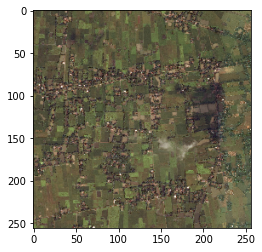

In [77]:
plt.imshow(np.transpose(train_batch['image'][0], (1, 2, 0)))

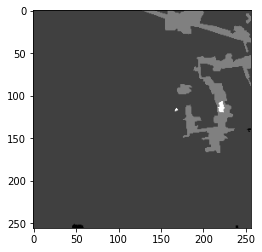

In [78]:
plt.imshow(np.transpose(train_batch['mask'][0], (1, 2, 0)), cmap='gray')

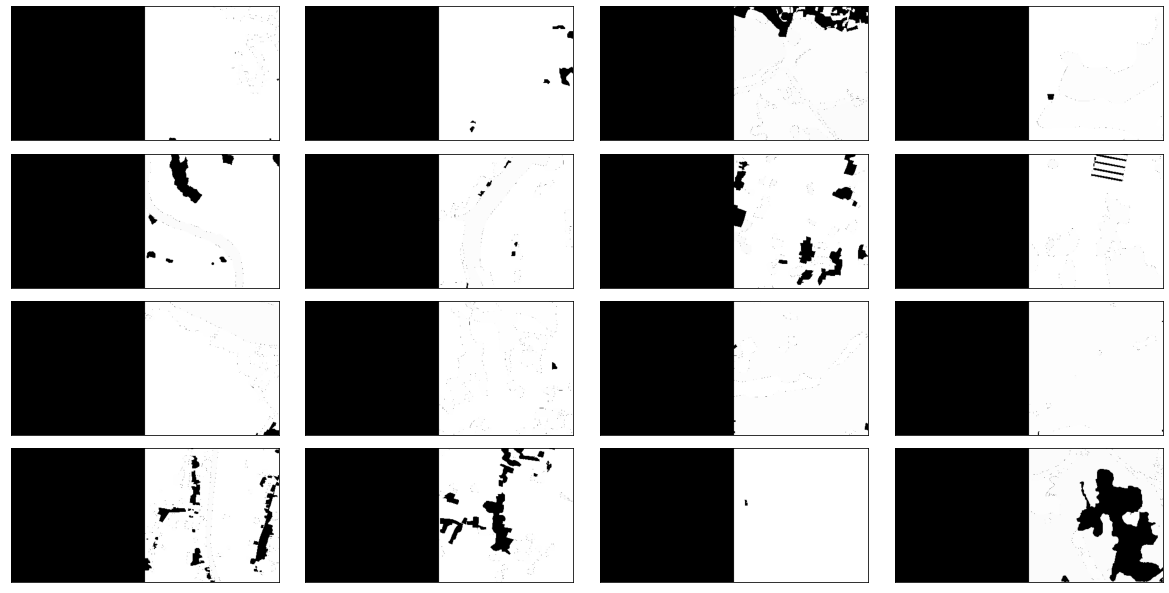

In [79]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(4, 4, figsize=(20, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=0.)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# Iterate over the first 25 test images
for idx in range(16):
    # Calculate the row and column index for the subplot
    row = idx // 4
    col = idx % 4

    image = train_batch['image'][idx].numpy()
    image = image.transpose((1, 2, 0)).squeeze()
    mask = train_batch['mask'][idx].numpy()
    mask = mask.transpose((1, 2, 0)).squeeze()
    mask = (mask * 255.0).astype("uint8")

    image_mask = np.zeros((256, 512, 3), dtype=np.uint8)

    image_mask[:, :256, :] = image
    image_mask[:, 256:, 0] = mask
    image_mask[:, 256:, 1] = mask
    image_mask[:, 256:, 2] = mask


    ax[row, col].imshow(image_mask)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

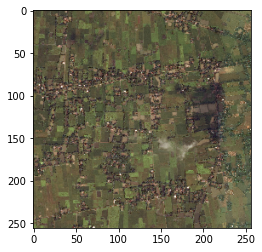

In [80]:
plt.imshow(np.transpose(train_batch['image'][0], (1, 2, 0)), cmap='gray')

In [81]:
class PetModel(L.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes):
        '''
            Initializes an instance of the SemanticSegmentation class.

            Parameters:
            - arch (str): The architecture of the model.
            - encoder_name (str): The name of the encoder.
            - in_channels (int): The number of input channels.
            - out_classes (int): The number of output classes.
        '''
        super().__init__()

        '''
            It is important to note that we are not using a trained encoder. To use a trained encoder, change
            The value in the encoder_weight parameter.
        '''
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=None)

        '''
           These are used to store the computed true positive, false positive, false negative and true negative 'pixels' for each image and class
        '''
        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        '''
            These are used to store the computed losses for each stage
        '''
        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        '''
            These parameters are used to normalize the input image. Models from the segmentation_models_pytorch library
            require the input image to be normalized. The mean and standard deviation values are used to normalize the image.
            The mean and standard deviation values are obtained from the get_preprocessing_params function of the encoders module.
        '''
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        '''
            Dice Loss: Dice loss, also known as the Sørensen-Dice coefficient, is a popular choice for image segmentation.
            It measures the overlap between the predicted and target segmentation masks.
        '''
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):

        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        '''
            Shape of the image should be (batch_size, num_channels, height, width)
            if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        '''
        assert image.ndim == 4

        '''
            Check that image dimensions are divisible by 32,
            encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
            downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
            following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
            and we will get an error trying to concat these features
        '''
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width] for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold: first convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        '''
            We will compute IoU metric by two ways
              1. dataset-wise
              2. image-wise
            but for now we just compute true positive, false positive, false negative and
            true negative 'pixels' for each image and class
            these values will be aggregated in the end of an epoch
        '''
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        '''
            Per image IoU means that we first calculate IoU score for each image
            and then compute mean over these scores
        '''
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        '''
            Dataset IoU means that we aggregate intersection and union over whole dataset
            and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            in this particular case will not be much, however for dataset
            with "empty" images (images without target class) a large gap could be observed.
            Empty images influence a lot on per_image_iou and much less on dataset_iou.
        '''
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    '''
        These are pytorch lightning hooks that are called during the training, validation and testing steps.
        Hooks are used to perform additional operations during these steps. In this case, we are using the hooks
        to compute the loss and metrics for each step and epoch.
    '''
    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [82]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)



In [83]:
# Early stop is a callback that is used to stop the training process when the validation loss does not improve. In this case, we are
# using the EarlyStopping callback to stop the training process when the validation loss does not improve for 3 epochs.
earlystop_callback = EarlyStopping('valid_loss', patience=3)

trainer = L.Trainer(max_epochs=15, logger=CSVLogger(save_dir="logs/", name="pets_seg-model"), callbacks=[earlystop_callback])

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


IndexError: list index out of range